In [1]:
# import numpy as np
# import random
# import pickle

import string
import pandas as pd
import re
import tensorflow as tf
# tf.enable_eager_execution()
# tf.executing_eagerly()

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
global encode_dict 
encode_dict = {l:i for i,l in enumerate(string.ascii_uppercase + " ", 1)}

In [3]:
#Maximum sequence length including padding
global MAXLEN
MAXLEN = 400

# Functions

In [4]:
# TEST_TXT = "Eirmod horrida ingénii pariant secundum? Cognitionem compositis conséquat dicantur exercitus, intellegitur invenire negat oportet sapientium suam. Ceteris diu erat fecerit, impéndéré intelleges máerores malorum mei re reprehendunt? Constringendos intus mentitum quale urna! Convenire cotidie dixit malé vigiliae?"

In [5]:
def preprocessInput(filename: str) -> pd.DataFrame:
    ''' Preprocess CSV file into a Pandas DataFrame.
    
    Expects the file name or path of a csv file with named columns containing strings representing product names.
    Returns a Pandas Dataframe containing uppercased versions of the strings on each cell.
    
    Parameters
    ----------
    filename : str
        
    Returns
    -------
    df : Pandas DataFrame
    '''  
    df = pd.read_csv(filename)
    print(df.info())
    
    print("Processing file: ---------------------------------------")
    original_count = len(df.index)
    print("Dropping sequences longer than the maxlen:")
    df.drop(df[df[df.columns[0]].apply(len).gt(MAXLEN)].index, inplace = True)
    df.drop(df[df[df.columns[1]].apply(len).gt(MAXLEN)].index, inplace = True)
    new_count = len(df.index)
    print("\tDropped", original_count - new_count, "that exceeded the maximum sequence length.")
    # Uppercase all values
    print("\tUppercasing string sequences.")
    df = df.applymap(lambda x: str.upper(x))
    print("Done processing: --------------------------------------")
    print(df.info())
    return df

In [6]:
def add_noise(w: str, percent: float = 0.1) -> str:
    ''' Adds a specified proportion of noise to a string.
    
    Expects a string and a number stating the percent of noise to add to this string.
    The string is modified by editing, deleting, or adding characters in/to the string.
    The modification to perform is determined randomly by generating a random number from an uniform distribution [0,1].
    If the number is < 1/3 edit one position with new random character.
    If the number is < 2/3 delete one position.
    Finally, if the number is > 2/3 add one random character. 
    
    Parameters
    ----------
    w : str
        The string to add noise to.
    
    percent: float, defaults to 10% if not specified
        Percentange representing the proportion of noise to add to the string.
        
        
    Returns
    -------
    w : str
        Modified string with noise added.
    '''  
    positions = random.choices(range(len(w)), k=int(percent*len(w)))
    print("Adding noise to", int(percent*len(w)), "% of the string")
    for p in positions:
        r = random.uniform(0,1)
        
        # if <1/3 edit one position with new random character, # else if <2/3 delete one position, else add one random character 
        if r <= 0.3333: # edit
            w = w[:p] + random.choice(string.ascii_uppercase) + w[p+1:]
        elif r<= 0.6667: # delete
            w = w[:p] + w[p+1:]
        else: # add
            w = w[:p] + random.choice(string.ascii_uppercase) + w[p:]
    return w

In [7]:
# add_noise(TEST_TXT)

In [8]:
# add_noise(TEST_TXT, .01)

In [9]:
def clean(text: str) -> str:
    '''Removes all the non-ascii and special characters from a string and returns the string's alphabetichal characters with spaces.
    
    Expects a string to be cleaned and removes all the non-ascii and special characters. 
    This is done by applying a substitution to regex matches
    Returns the cleaned string containing uppercased versions of the characters.
    
    Parameters
    ----------
    text : str
        
    Returns
    -------
    text : str
    '''
    regex = re.compile('[^a-zA-Z ]')
    r = regex.sub('', text)
    result = re.sub(' +', ' ', r)
    result = result.strip()
    return result.upper()

In [10]:
# clean(TEST_TXT)

In [11]:
def clean_dataset(x: pd.Series, y: pd.Series) -> (pd.Series, pd.Series):
    '''Applies the cleaning function to the dataset.
    
    Expects two Pandas Series, namely the 'FAERS_drug_match' and the 'lookup_value' columns.
    Applies the cleaning function to them and returns them separately.
    
    Parameters
    ----------
    x : pd.Series
        A pandas Series containing the 'FAERS_drug_match' column.
    y : pd.Series
        A pandas Series containing the 'lookup_value' column.
      
    Returns
    -------
    x : pd.Series
        Returns the cleaned 'FAERS_drug_match' series.
    y : pd.Series 
        Returns the cleaned 'lookup_value' series.
    '''
    return x.apply(clean), y.apply(clean)

In [12]:
# clean_dataset(test)

In [13]:
def encode_dataset(x: pd.Series, y: pd.Series) -> (pd.Series, pd.Series):
    '''Applies the encoding function to the dataset.
    
    Expects two cleaned Pandas Series, namely the 'FAERS_drug_match' and the 'lookup_value' columns.
    Returns these Series enconded into an array containing an integer mapping to each character and space (1-66) separately.
    
    Parameters
    ----------
    x : pd.Series
        A pandas Series containing the clean 'FAERS_drug_match' column.
    y : pd.Series
        A pandas Series containing the clean 'lookup_value' column.
      
    Returns
    -------
    x : pd.Series
        Returns the encoded 'FAERS_drug_match' series.
    y : pd.Series 
        Returns the encoded 'lookup_value' series.
    '''
    return x.apply(lambda string: list(map(encode_dict.get, string))), y.apply(lambda string: list(map(encode_dict.get, string)))

In [14]:
# encode_dataset(*clean_dataset(test))[0].head()

In [15]:
# def clean_encode_padding(q, maxlen):
#     q = clean(q)
#     return tf.keras.preprocessing.sequence.pad_sequences(
#         [encode_dict[m] for m in q] , padding="post", maxlen=maxlen)

In [16]:
def padding_dataset(X: pd.Series,Y: pd.Series, maxlen: int = MAXLEN) -> (pd.Series, pd.Series):
    '''Applies the padding function to the dataset.
    
    Expects two cleaned and encoded Pandas Series, namely the 'FAERS_drug_match' and the 'lookup_value' columns.
    Returns the enconded Series padded.
    
    Parameters
    ----------
    x : pd.Series
        A pandas Series containing the clean encoded 'FAERS_drug_match' column.
    y : pd.Series
        A pandas Series containing the clean encoded 'lookup_value' column.
      
    Returns
    -------
    x : pd.Series
        Returns the padded 'FAERS_drug_match' series.
    y : pd.Series 
        Returns the padded 'lookup_value' series.
    '''
    return X.transform(lambda x: x + ([0]* (maxlen-len(x)))), Y.transform(lambda x: x + ([0]* (maxlen-len(x))))
#     return tf.keras.preprocessing.sequence.pad_sequences(X, padding="post", maxlen=maxlen), tf.keras.preprocessing.sequence.pad_sequences(Y, padding="post", maxlen=maxlen)

In [17]:
# padding_dataset(*encode_dataset(*clean_dataset(test)), MAXLEN)[0].head()

In [18]:
def generate_negative_pairs() -> (pd.Series, pd.Series):
    '''Create negative pairs where 'FAERS_drug_match' does not match the correct 'lookup_value'.

    For each unique name in the 'FAERS_drug_match' column of the train set, get the product name
    and then pick four random different product names. For each of those 4 additional product names 
    check if it matches any of the names in the training set if its not then add it to the dataset as 
    a negative pair. The goal of this is to help further distance the embeddings in the vector space.

    
    Parameters
    ----------
    The function has no parameters but it expects a Pandas dataframe called Unique_df
    containing the 'dUnique_label' series and another Pandas dataframe called train
    containing the 'FAERS_drug_match' and the 'lookup_value' series.

    Returns
    -------
    faers_match : pd.Series
        Returns the 'FAERS_drug_match' series.
    lookup : pd.Series 
        Returns the 'lookup_value' series.
    '''
    faers_match = []
    lookup = []
    for np_name in train['FAERS_drug_match']:
        np_temp = dUnique_df['dUnique_label'][dUnique_df['dUnique_label'] != np_name].sample(4)
        np_temp = np_temp[~np_temp.isin(train['lookup_value'].loc[train['FAERS_drug_match'] == np_name])]     
        faers_match.extend([np_name]* len(np_temp))
        lookup.extend(np_temp)
    return faers_match, lookup

------------------------------------------------

# Data loading and preprocessing

In [19]:
fName = '../data/NP_FAERS_mapped_20220215.csv'
fName_unmapped = '../unmapped_data/upper_unmap_orig_drug_names_202201201812.csv'
fName_negatives = '../data/NP_FAERS_negative_pairs_20220222.csv'

## Create the train/test split

In [20]:
train, test = train_test_split(preprocessInput(fName), test_size=0.20, random_state = 42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  5358 non-null   object
 1   lookup_value      5358 non-null   object
dtypes: object(2)
memory usage: 83.8+ KB
None
Processing file: ---------------------------------------
Dropping sequences longer than the maxlen:
	Dropped 6 that exceeded the maximum sequence length.
	Uppercasing string sequences.
Done processing: --------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5352 entries, 0 to 5357
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  5352 non-null   object
 1   lookup_value      5352 non-null   object
dtypes: object(2)
memory usage: 125.4+ KB
None


In [21]:
print("Train:", train.shape, "Test:" , test.shape)

Train: (4281, 2) Test: (1071, 2)


## Clean, Encode and Pad the datasets

In [22]:
padded_xTest, padded_yTest = padding_dataset(*encode_dataset(*clean_dataset(test.FAERS_drug_match, test.lookup_value)))

In [23]:
x, y = clean_dataset(train.FAERS_drug_match, train.lookup_value)
padded_x, padded_y = padding_dataset(*encode_dataset(x,y))

In [24]:
negative_set = preprocessInput(fName_negatives)
padded_xneg, padded_yneg = padding_dataset(*encode_dataset(*clean_dataset(negative_set.FAERS_drug_match, negative_set.lookup_value)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9242 entries, 0 to 9241
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  9242 non-null   object
 1   lookup_value      9242 non-null   object
dtypes: object(2)
memory usage: 144.5+ KB
None
Processing file: ---------------------------------------
Dropping sequences longer than the maxlen:
	Dropped 2 that exceeded the maximum sequence length.
	Uppercasing string sequences.
Done processing: --------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9240 entries, 0 to 9241
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  9240 non-null   object
 1   lookup_value      9240 non-null   object
dtypes: object(2)
memory usage: 216.6+ KB
None


In [25]:
print("Test padded x:", padded_xTest.shape, "Test padded y:", padded_yTest.shape)
print("Train padded x:", padded_x.shape, "Train padded y:", padded_y.shape)
print("Train padded x_neg:", padded_xneg.shape, "Train padded y_neg:", padded_yneg.shape)

Test padded x: (1071,) Test padded y: (1071,)
Train padded x: (4281,) Train padded y: (4281,)
Train padded x_neg: (9240,) Train padded y_neg: (9240,)


## Creating Pandas DF for simplified view of the dataset 

In [26]:
dUnique_df = pd.DataFrame(columns = ['dUnique_label','dUnique_seq', 'dUnique_seq_padded'])
dUnique_df['dUnique_label'] = y.unique()
dUnique_df['dUnique_seq'] = dUnique_df['dUnique_label'].transform(lambda x: list(map(encode_dict.get,list(x))))
dUnique_df['dUnique_seq_padded'] = list(tf.keras.preprocessing.sequence.pad_sequences(dUnique_df['dUnique_seq'].array, padding="post", maxlen=MAXLEN))
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,CRANBERRY,"[3, 18, 1, 14, 2, 5, 18, 18, 25]","[3, 18, 1, 14, 2, 5, 18, 18, 25, 0, 0, 0, 0, 0..."
1,SERENOA REPENS,"[19, 5, 18, 5, 14, 15, 1, 27, 18, 5, 16, 5, 14...","[19, 5, 18, 5, 14, 15, 1, 27, 18, 5, 16, 5, 14..."
2,ECHINACEA PURPUREA,"[5, 3, 8, 9, 14, 1, 3, 5, 1, 27, 16, 21, 18, 1...","[5, 3, 8, 9, 14, 1, 3, 5, 1, 27, 16, 21, 18, 1..."
3,CINNAMON,"[3, 9, 14, 14, 1, 13, 15, 14]","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0..."
4,LEPIDIUM MEYENII,"[12, 5, 16, 9, 4, 9, 21, 13, 27, 13, 5, 25, 5,...","[12, 5, 16, 9, 4, 9, 21, 13, 27, 13, 5, 25, 5,..."


## Add positive pairs
Data from NP_FAERS_mapped_20220215.csv -- the manually create references set for ~70 drugs

In [27]:
x1TrainRNN = list(padded_x)
x2TrainRNN = list(padded_y)
yTrainRNN = [1] * len(padded_x)
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

4281 4281 4281


## Add negative pairs from unmmaped
Data from NP_FAERS_negative_pairs_20220222.csv -- the negative pairs created by random sampling from the NP_FAERS_mapped_20220215.csv

In [28]:
yTrainRNN.extend([0] * len(padded_xneg))
x1TrainRNN.extend(padded_xneg)
x2TrainRNN.extend(padded_yneg)
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

13521 13521 13521


## Generate additional negative pairs

In [29]:
faers_match, lookup = generate_negative_pairs()

In [30]:
dfneg2 = pd.DataFrame(columns=['FAERS_drug_match', 'lookup_value'])
dfneg2['FAERS_drug_match'] = faers_match 
dfneg2['lookup_value'] = lookup
padded_xneg2, padded_yneg2 = padding_dataset(*encode_dataset(*clean_dataset(dfneg2.FAERS_drug_match, dfneg2.lookup_value)), MAXLEN)

## Add additional negative pairs 
Generated from training data using generate_negative_pairs

In [31]:
yTrainRNN.extend([0] * len(padded_xneg2))
x1TrainRNN.extend(padded_xneg2)
x2TrainRNN.extend(padded_yneg2)
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

30409 30409 30409


In [32]:
x1TrainRnnS, x1ValRnnS, x2TrainRnnS, x2ValRnnS, yTrainRnnS, yValRnnS = train_test_split(x1TrainRNN, x2TrainRNN, yTrainRNN, test_size=0.20, random_state=42)

In [33]:
len(x1TrainRnnS)

24327

# Save data to csv

In [34]:
pd.DataFrame(data={"x1": x1TrainRnnS, "x2": x2TrainRnnS, "y": yTrainRnnS}).to_pickle("../data/proccesed_train_set.pkl")
pd.DataFrame(data={"x1": x1ValRnnS, "x2": x2ValRnnS, "y": yValRnnS}).to_pickle("../data/proccesed_test_set.pkl")

In [35]:
dUnique_df.to_pickle("../data/dUnique_df.pkl")
dfneg2.to_pickle("../data/dfneg2.pkl")

----------------------------------

# Average NP name length 

In [20]:
main_dataset = preprocessInput(fName)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
FAERS_drug_match    5358 non-null object
lookup_value        5358 non-null object
dtypes: object(2)
memory usage: 83.8+ KB
None
Processing file: ---------------------------------------
Dropping sequences longer than the maxlen:
	Dropped 6 that exceeded the maximum sequence length.
	Uppercasing string sequences.
Done processing: --------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5352 entries, 0 to 5357
Data columns (total 2 columns):
FAERS_drug_match    5352 non-null object
lookup_value        5352 non-null object
dtypes: object(2)
memory usage: 125.4+ KB
None


In [21]:
stats = main_dataset['FAERS_drug_match'].apply(len).describe()
stats

count    5352.000000
mean       29.128176
std        26.200619
min         3.000000
25%        15.000000
50%        22.000000
75%        37.000000
max       364.000000
Name: FAERS_drug_match, dtype: float64

In [22]:
stats["mean"] + stats["std"] * 2

81.52941485381506

In [23]:
main_dataset['lookup_value'].apply(len).describe()

count    5352.000000
mean       13.592302
std         4.743080
min         4.000000
25%         9.000000
50%        14.000000
75%        18.000000
max        24.000000
Name: lookup_value, dtype: float64

In [24]:
main_dataset['FAERS_drug_match'].apply(len).sort_values(ascending=False)[0:10]

3261    364
65      364
1098    364
3777    364
582     364
2744    364
3767    356
1088    356
57      301
2736    301
Name: FAERS_drug_match, dtype: int64

In [25]:
main_dataset['FAERS_drug_match'].apply(len).gt(80).describe()

count      5352
unique        2
top       False
freq       5238
Name: FAERS_drug_match, dtype: object

In [42]:
print("Gt 65:", 5358 - 4984)
print("Gt 70:", 5358 - 5212)
print("Gt 80:", 5358 - 5238)

Gt 65: 374
Gt 70: 146
Gt 80: 120


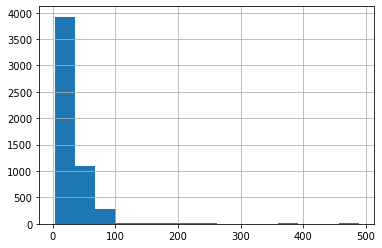

In [32]:
%matplotlib inline
main_dataset['FAERS_drug_match'].apply(len).hist(bins=15)

In [26]:
main_dataset.iloc[5132]['FAERS_drug_match']

"WOMEN'S MULTI (ASCORBIC ACID, BETACAROTENE, BIOTIN, CALCIUM AMINO ACID CHELATE, CALCIUM PANTOTHENATE, CHROMIUM AMINO ACID CHELATE, COPPER AMINO ACID CHELATE, CYANOCOBALAMIN, EQUISETUM ARVENSE STEM, FERROUS FUMARATE, FOLIC ACID, LAMINARIA DIGITATA POWDER, MAGNESIUM OXIDE, MANGANESE AMINO ACID CHELATE, NICOTINAMIDE, OENOTHERA BIENNIS OIL, POTASSIUM AMINO ACID CHELATE, PYRIDOXINE HYDROCHLORIDE, RIBOFLAVIN, SELENIUM AMINO ACID CHELATE, THIAMINE MONONITRATE, ZINC AMINO ACID CHELATE) TABLET"

In [ ]:
main_dataset.iloc[5132]['FAERS_drug_match']

In [133]:
dfneg2['FAERS_drug_match'].apply(len).describe()

count    16879.000000
mean        29.855738
std         31.324787
min          3.000000
25%         15.000000
50%         22.000000
75%         37.000000
max        489.000000
Name: FAERS_drug_match, dtype: float64

In [ ]:
dfneg2['lookup_value'].apply(len).describe()

In [134]:
dUnique_df['dUnique_label'].apply(len).describe()

count    125.000000
mean      13.136000
std        4.590214
min        4.000000
25%        9.000000
50%       13.000000
75%       17.000000
max       24.000000
Name: dUnique_label, dtype: float64

In [132]:
dUnique_df['dUnique_seq'].apply(len).describe()

count    125.000000
mean      13.136000
std        4.590214
min        4.000000
25%        9.000000
50%       13.000000
75%       17.000000
max       24.000000
Name: dUnique_seq, dtype: float64

In [ ]:
dfneg2['FAERS_drug_match'].apply(len).idxmax()

In [138]:
dfneg2.iloc[8183]['FAERS_drug_match']

"WOMEN'S MULTI (ASCORBIC ACID, BETACAROTENE, BIOTIN, CALCIUM AMINO ACID CHELATE, CALCIUM PANTOTHENATE, CHROMIUM AMINO ACID CHELATE, COPPER AMINO ACID CHELATE, CYANOCOBALAMIN, EQUISETUM ARVENSE STEM, FERROUS FUMARATE, FOLIC ACID, LAMINARIA DIGITATA POWDER, MAGNESIUM OXIDE, MANGANESE AMINO ACID CHELATE, NICOTINAMIDE, OENOTHERA BIENNIS OIL, POTASSIUM AMINO ACID CHELATE, PYRIDOXINE HYDROCHLORIDE, RIBOFLAVIN, SELENIUM AMINO ACID CHELATE, THIAMINE MONONITRATE, ZINC AMINO ACID CHELATE) TABLET"